In [34]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [35]:
df = pd.read_csv('fraudTest.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [36]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [37]:
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city','state', 'zip', 'dob', 'job', 'trans_num']
df = df.drop(columns= drop_columns)

In [38]:
df.head()


,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0,12,21,6
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,F,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0,12,21,6
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0,12,21,6
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,M,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0,12,21,6
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,M,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0,12,21,6


In [39]:
cat_col = ['merchant', 'category', 'gender']
encoders = {}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])


In [40]:
def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [41]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2291163933867244,319,10,2.86,1,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0,12,21,6,24.613746
1,3573030041201292,591,10,29.84,0,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0,12,21,6,104.834043
2,3598215285024754,611,5,41.28,0,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0,12,21,6,59.204796
3,3591919803438423,222,9,60.05,1,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0,12,21,6,27.615117
4,3526826139003047,292,13,3.19,1,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0,12,21,6,104.423175


In [42]:
features = ['merchant','category', 'amt', 'cc_num', 'hour', 'day', 'month', 'gender', 'distance' ]
x= df[features]
y= df['is_fraud']

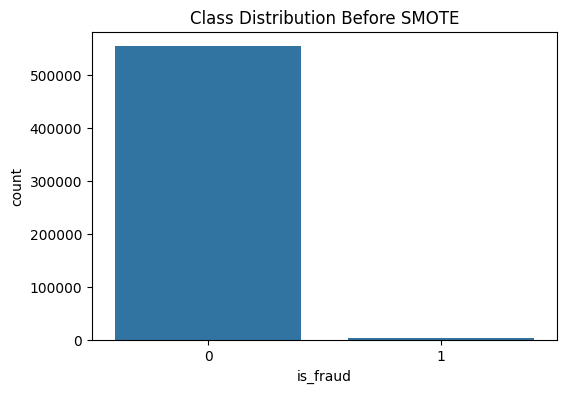

In [43]:
plt.figure(figsize=(6,4))
sns.countplot(x= 'is_fraud', data=df)
plt.title("Class Distribution Before SMOTE")
plt.show()

In [44]:
smote = SMOTE(random_state=42)
x_resample, y_resample= smote.fit_resample(x,y)

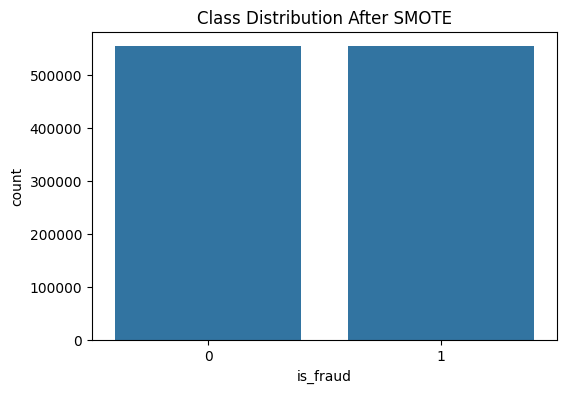

In [45]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

In [47]:
lgb_model= lgb.LGBMClassifier(
    boosting_type= 'gbdt',
    objective= 'binary',
    metrics= 'auc',
    is_unbalance= True,
    learning_rate= 0.05,
    num_leaves= 31,
    max_depth= 1,
    n_estimators= 200
    )
lgb_model.fit(x_resample, y_resample)

[LightGBM] [Info] Number of positive: 553574, number of negative: 553574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 1107148, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=1,
               metrics='auc', n_estimators=200, objective='binary')

In [48]:
y_pred = lgb_model.predict(x_test)

In [49]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Roc AUC Score:\n", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.87    110422
           1       0.94      0.78      0.85    111008

    accuracy                           0.86    221430
   macro avg       0.88      0.86      0.86    221430
weighted avg       0.88      0.86      0.86    221430

Roc AUC Score:
 0.8644055849665008


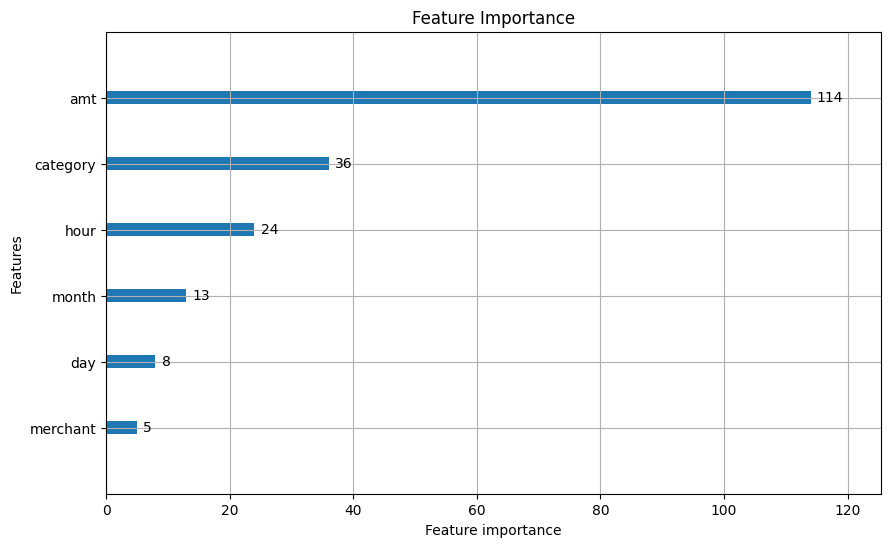

In [50]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10,6))
plt.title("Feature Importance")
plt.show()

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

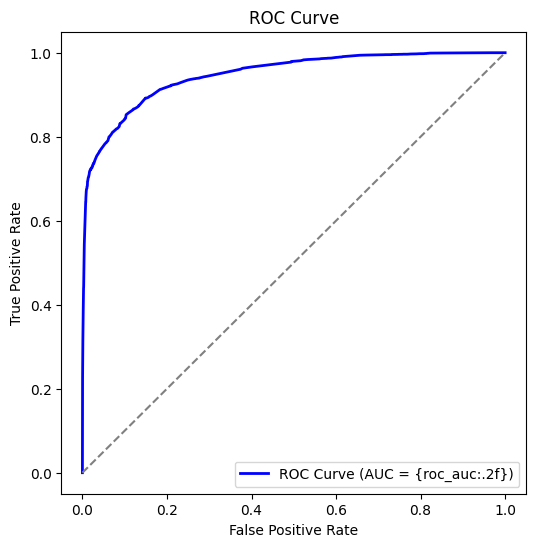

In [52]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label= 'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc= 'lower right')
plt.show()

In [53]:
joblib.dump(lgb_model, "Fraud_detection_model.jb")
joblib.dump(encoders, "label_encoders.jb")

['label_encoders.jb']

In [54]:
df[df['is_fraud']==1].head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
1685,3560725013359375,226,5,24.84,0,31.8599,-102.7413,23,1371852399,32.575873,-102.604290,1,22,21,6,80.438371
1767,6564459919350820,523,8,780.52,1,42.5545,-90.3508,1306,1371853942,42.461127,-91.147148,1,22,21,6,66.267361
1781,6564459919350820,451,0,620.33,1,42.5545,-90.3508,1306,1371854247,42.771834,-90.158365,1,22,21,6,28.840604
1784,4005676619255478,238,11,1077.69,1,30.4590,-90.9027,71335,1371854335,31.204974,-90.261595,1,22,21,6,102.964988
1857,3560725013359375,246,12,842.65,0,31.8599,-102.7413,23,1371855736,31.315782,-102.736390,1,23,21,6,60.333400
